## 搭建一个简单的问答系统

本次项目的目标是搭建一个基于检索式的简单的问答系统。 

知识点：
1. 字符串操作   2. 文本预处理技术（词过滤，标准化）   3. 文本的表示（tf-idf, word2vec)  4. 文本相似度计算  5. 文本高效检索

此项目需要的数据：
1. [train-v2.0.json](https://github.com/SixGreen/small-programs/blob/master/data/train-v2.0.json): 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
2. [glove.6B](https://nlp.stanford.edu/projects/glove/): 使用d=100的词向量

**检索式的问答系统**

问答系统所需要的数据已经提供，对于每一个问题都可以找得到相应的答案，所以可以理解为每一个样本数据是 <问题、答案>。 那系统的核心是当用户输入一个问题的时候，首先要找到跟这个问题最相近的已经存储在库里的问题，然后直接返回相应的答案即可。 举一个简单的例子：

假设我们的库里面已有存在以下几个<问题,答案>：
<"人工智能和机器学习的关系什么？", "其实机器学习是人工智能的一个范畴，很多人工智能的应用要基于机器学习的技术">
<"人工智能最核心的语言是什么？"， "Python">
.....

假设一个用户往系统中输入了问题 “机器学习与人工智能有什么关系？”， 那这时候系统先去匹配最相近的“已经存在库里的”问题。 那在这里很显然是 “机器学习与人工智能有什么关系”和“人工智能和机器学习的关系什么”是最相近的。 所以当我们定位到这个问题之后，直接返回它的答案 “其实机器学习是人工智能的一个范畴，很多人工智能的应用要基于机器学习的技术”就可以了。所以这里的核心问题可以归结为计算两个问句（query）之间的相似度。

在本次项目中，你会频繁地使用到[sklearn](http://scikit-learn.org/stable/install.html)这个机器学习库，sklearn包含了各类机器学习算法和数据处理工具，包括本项目需要使用的词袋模型。

### 读取文件，并把内容分别写到两个list里（一个list对应问题集，另一个list对应答案集）

In [77]:
import json

def read_corpus(filepath):
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分要在后面处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（下标位置一致）
    """
    with open(filepath) as f:
        data = json.load(f)
        
    qlist = list()
    alist = list()
    for item in data['data']:
        for para in item['paragraphs']:
            for qa in para['qas']:
                qlist.append(qa['question'])
                # 部分answers的list为空，所以会引发IndexError
                try:
                    alist.append(qa['answers'][0]['text'])
                except IndexError:
                    qlist.pop()
        
    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, alist

In [79]:
# 测试
qlist, alist = read_corpus('./data/train-v2.0.json')
print("问答数量：%d" % len(qtmp))
print(qlist[-3:])
print(alist[-3:])

问答数量：86821
['With what Belorussian city does Kathmandu have a relationship?', 'In what year did Kathmandu create its initial international relationship?', 'What is KMC an initialism of?']
['Minsk', '1975', 'Kathmandu Metropolitan City']


### 理解数据（可视化分析/统计信息）
对数据的理解是任何AI工作的第一步，需要充分对手上的数据有个更直观的理解。 

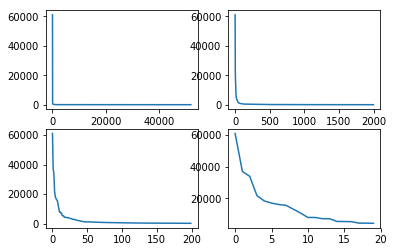

词数(type)：51841
[['the', 60960], ['What', 36995], ['of', 33987], ['in', 21785], ['to', 18443], ['was', 17065], ['is', 16198], ['did', 15634], ['what', 13219], ['a', 10753], ['How', 8023], ['Who', 8009], ['and', 7229], ['for', 7200], ['many', 5497], ['are', 5455], ['When', 5367], ['that', 4436], ['were', 4428], ['does', 4331]]


In [80]:
# TODO: 统计一下qlist中每个单词出现的频率，并把这些频率排一下序，然后画成plot. 比如总共出现了总共7个不同单词，而且每个单词出现的频率为 4, 5,10,2, 1, 1,1
#       把频率排序之后就可以得到(从大到小) 10, 5, 4, 2, 1, 1, 1. 然后把这7个数plot即可（从大到小）
#       需要使用matplotlib里的plot函数。y轴是词频
from collections import Counter
import matplotlib.pyplot as plt

qlist, alist = read_corpus('./data/train-v2.0.json')

words_cnt = Counter()
for text in qlist:
    words_cnt.update(text.strip(' .!?').split(' '))

value_sort = sorted(words_cnt.values(), reverse=True)
plt.subplot(221)
plt.plot(value_sort)
plt.subplot(222)
plt.plot(value_sort[:2000])
plt.subplot(223)
plt.plot(value_sort[:200])
plt.subplot(224)
plt.plot(value_sort[:20])
plt.show()

# 显示词频最高前10词，因为只取高频值，所以value转换时重合的概率较小，即时重合也没有太大影响
inverse = dict(zip(words_cnt.values(), words_cnt.keys()))
print("词数(type)：%d" % len(words_cnt))
print([[inverse[v], v] for v in value_sort[:20]])

本来是想契合下zipf定律的，但是不是非常理想，只能看出形状来，主要原因应该是问答趋于同质化。另外明显看到虚词出现频率很高，所以可能需要去停用词。

### 文本预处理
在这里我们面对的是英文文本，所以任何对英文适合的技术都可以考虑进来。中文和英文类似，多了分词处理但不需要stemming。

In [83]:
# TODO: 对于qlist做文本预处理操作（不要对alist进行操作，因为答案直接调用即可，我们只匹配问题）。 可以考虑以下几种操作：
#       1. 停用词过滤 （去网上搜一下 "english stop words list"，会出现很多包含停用词库的网页，或者直接使用NLTK自带的）   
#       2. 转换成lower_case： 这是一个基本的操作
#       3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
#       4. 去掉出现频率很低的词：比如出现次数少于10,20....
#       5. 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
#       6. stemming（利用porter stemming): 因为是英文，所以stemming也是可以做的工作
#       7. 也可以做下词形还原，但是在这个任务里个人感觉不是很有必要
#       请注意，不一定要按照上面的顺序来处理
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import math

# 加载nltk自带停用词，该停用词表个人感觉一般，具体到细分领域可能还是需要自己归纳
sw = set(stopwords.words('english'))
# 个人感觉对于一个问题而言这些词不应该删去
sw -= {'who', 'when', 'why', 'where', 'how'}
# 这里只是随便去了下符号
sw.update(['\'s', '``', '\'\''])
ps = PorterStemmer()

def text_preprocessing(text):
    """
    对单条文本进行处理。
    text: str类型
    
    return: 分词后的list
    """
    
    seg = list()
    # 直接用nltk分词
    for word in word_tokenize(text):
        # 小写化、词干提取
        word = ps.stem(word.lower())
        # 数值归一
        word = '#number' if word.isdigit() else word
        # 去停用词
        if len(word)>1 and word not in sw:
            seg.append(word)
    
    return seg

words_cnt = Counter()
qlist_seg = list()
for text in qlist:
    seg = text_preprocessing(text)
    qlist_seg.append(seg)
    words_cnt.update(seg)
    
value_sort = sorted(words_cnt.values(), reverse=True)
# 根据Zipf定律计算99%覆盖率下的过滤词频，解释见程序下边
min_tf = value_sort[int(math.exp(0.99 * math.log(len(words_cnt))))]
for cur in range(len(qlist_seg)):
    qlist_seg[cur] = [word for word in qlist_seg[cur] if words_cnt[word] > min_tf]

词频的过滤阈值是按照Zipf定律来算的，没见别人这么用过，自己感觉还算合理。

Zipf's law一个实验定律，按照从最常见到非常见排列，第二常见的频率是最常见频率的出现次数的1/2，第三常见的频率是最常见的频率的1/3，第n常见的频率是最常见频率出现次数的1/n。

假设我们文本的词频符合该定律，那么对1/n进行积分得到ln(n)，为了使99%的文本得到覆盖则需ln(x)>0.99\*ln(n)，n是词type数，x是词频从高到底排列时的阈值分割点，最后x=e^(0.99\*ln(n))。

In [84]:
# 测试
print(qlist_seg[:10])

[['when', 'beyonc', 'start', 'becom', 'popular'], ['area', 'beyonc', 'compet', 'when', 'wa', 'grow'], ['when', 'beyonc', 'leav', 'destini', 'child', 'becom', 'solo', 'singer'], ['citi', 'state', 'beyonc', 'grow'], ['decad', 'beyonc', 'becom', 'famou'], ['group', 'wa', 'lead', 'singer'], ['album', 'made', 'worldwid', 'known', 'artist'], ['who', 'manag', 'destini', 'child', 'group'], ['when', 'beyoncé', 'rise', 'fame'], ['role', 'beyoncé', 'destini', 'child']]


### 文本表示
做完关键的预处理过程之后，就需要把每一个文本转换成向量。

In [85]:
# TODO: 把qlist中的每一个问题字符串转换成tf-idf向量, 转换之后的结果存储在X矩阵里。 X的大小是： N* D的矩阵。 这里N是问题的个数（样本个数），
#       D是字典库的大小。 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() # 定义一个tf-idf的vectorizer

X = vectorizer.fit_transform([' '.join(seg) for seg in qlist_seg])  # 结果存放在X矩阵

In [86]:
# 测试
def sparsity_ratio(X):
    return 1.0 - X.nnz / float(X.shape[0] * X.shape[1])

print(X.shape)
print("input sparsity ratio:", sparsity_ratio(X))  # 打印出稀疏度(sparsity)

(86821, 14548)
input sparsity ratio: 0.9995937135512636


### 对于用户的输入问题，找到相似度最高的TOP5问题，并把5个潜在的答案做返回

In [89]:
from queue import PriorityQueue

def top5results(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    q_vector = vectorizer.transform([' '.join(text_preprocessing(input_q))])
    # 计算余弦相似度，tfidf默认使用l2范数；矩阵乘法
    sim = (X * q_vector.T).toarray()

    # 使用优先队列找出top5
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], cur))
        if len(pq.queue) > 5:
            pq.get()
    
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    # print([x[0] for x in pq_rank])
    top_idxs = [x[1] for x in pq_rank]  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
    
    return [alist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

In [90]:
# 测试
print(top5results("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results("Which airport is closed?"))
print(top5results("What government blocked aid after Cyclone Nargis?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results("Which government stopped aid after Hurricane Nargis?"))

[0.9999999999999999, 0.9999999999999999, 0.6058098700501424, 0.5955903794475756, 0.5604486086527194]
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'aerodrome with facilities for flights to take off and land', 'newspapers', 'various gaming sites']
[0.7797154765957257, 0.7103241311289762, 0.7038747251719334, 0.6245909883904857, 0.5811739588019266]
['Plymouth City Airport', 'aerodrome with facilities for flights to take off and land', 'related', 'After the reunification', 'Nanjing Dajiaochang Airport']
[0.9999999999999998, 0.7852110277213404, 0.49331031138548864, 0.4162177525363464, 0.33229596712940707]
['Myanmar', 'foreign aid', '10 days', 'the British government', 'The latent heat of water condensation amplifies convection']
[0.5947629389746683, 0.39360612204759465, 0.35791876809775003, 0.31237667954304615, 0.2999699083743183]
['Myanmar', 'Isabel', 'foreign aid', 'Soviet Union and China', '10 days']


可以明显发现，tfidf方法是很难处理语义相似的问题的。

### 利用倒排表的优化。 
上面的算法，一个最大的缺点是每一个用户问题都需要跟库里的所有的问题都计算相似度。假设我们库里的问题非常多，这将是效率非常低的方法。 这里面一个方案是通过倒排表的方式，先从库里面找到跟当前的输入类似的问题描述。然后针对于这些candidates问题再做余弦相似度的计算。这样会节省大量的时间。

In [92]:
# TODO: 基于倒排表的优化。在这里，我们可以定义一个类似于hash_map, 比如 inverted_index = {}， 然后存放包含每一个关键词的文档出现在了什么位置，
#       也就是，通过关键词的搜索首先来判断包含这些关键词的文档（比如出现至少一个），然后对于candidates问题做相似度比较。
from collections import defaultdict

inverted_idx = defaultdict(set)  # 制定一个一个简单的倒排表
for cur in range(len(qlist_seg)):
    for word in qlist_seg[cur]:
        inverted_idx[word].add(cur)
    
def top5results_invidx(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """
    seg = text_preprocessing(input_q)
    candidates = set()
    for word in seg:
        # 取所有包含任意一个词的文档的并集
        candidates = candidates | inverted_idx[word]
    candidates = list(candidates)
    
    q_vector = vectorizer.transform([' '.join(seg)])
    # 计算余弦相似度，tfidf用的l2范数，所以分母为1；矩阵乘法
    sim = (X[candidates] * q_vector.T).toarray()

    # 使用优先队列找出top5
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], candidates[cur]))
        if len(pq.queue) > 5:
            pq.get()
    
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    print([x[0] for x in pq_rank])
    top_idxs = [x[1] for x in pq_rank]  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
    
    return [alist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案  

In [93]:
# 测试
print(top5results_invidx("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_invidx("Which airport is closed?"))
print(top5results_invidx("What government blocked aid after Cyclone Nargis?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_invidx("Which government stopped aid after Hurricane Nargis?"))

[1.0, 1.0, 0.6058098700501424, 0.5955903794475756, 0.5604486086527194]
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'aerodrome with facilities for flights to take off and land', 'newspapers', 'various gaming sites']
[0.7797154765957257, 0.7103241311289762, 0.7038747251719334, 0.6245909883904857, 0.5811739588019266]
['Plymouth City Airport', 'aerodrome with facilities for flights to take off and land', 'related', 'After the reunification', 'Nanjing Dajiaochang Airport']
[0.9999999999999998, 0.7852110277213404, 0.49331031138548864, 0.4162177525363464, 0.33229596712940707]
['Myanmar', 'foreign aid', '10 days', 'the British government', 'The latent heat of water condensation amplifies convection']
[0.5947629389746683, 0.39360612204759465, 0.35791876809775003, 0.31237667954304615, 0.2999699083743183]
['Myanmar', 'Isabel', 'foreign aid', 'Soviet Union and China', '10 days']


### 基于词向量的文本表示
上面所用到的方法论是基于词袋模型（bag-of-words model）。这样的方法论有两个主要的问题：1. 无法计算词语之间的相似度  2. 稀疏度很高。 接下来我们采用词向量作为文本的表示，下载训练好的d=100（100维）的词向量[glove.6B.zip](https://nlp.stanford.edu/projects/glove/)。


In [96]:
# TODO
# 读取每一个单词的嵌入。
# 句子向量 = 词向量的平均（出现在问句里的）， 如果给定的词没有出现在词典库里，则忽略掉这个词。
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np

# 将GloVe转为word2vec
_ = glove2word2vec('./data/glove.6B.100d.txt', './data/glove2word2vec.6B.100d.txt')
model = KeyedVectors.load_word2vec_format('./data/glove2word2vec.6B.100d.txt')

def docvec_get(seg):
    """
    将分词数据转为句向量。
    seg: 分词后的数据
    
    return: 句向量
    """
    vector = np.zeros((1, 100))
    size = len(seg)
    for word in seg:
        try:
            vector += model.wv[word]
        except KeyError:
            size -= 1
    
    return vector / size

X = np.zeros((len(qlist_seg), 100))
for cur in range(X.shape[0]):
    X[cur] = docvec_get(qlist_seg[cur])

# 计算X每一行的l2范数
Xnorm2 = np.linalg.norm(X, axis=1, keepdims=True)
X = X / Xnorm2

def top5results_emb(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q，转换成句子向量
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """
    # 用词向量后用词形还原更合理，此处就不做变更了
    seg = text_preprocessing(input_q)
    # 直接用上边建好的倒排表
    candidates = set()
    for word in seg:
        # 取所有包含任意一个词的文档的并集
        candidates = candidates | inverted_idx[word]
    candidates = list(candidates)
    
    q_vector = docvec_get(seg)
    # 计算问题向量的l2范数
    qnorm2 = np.linalg.norm(q_vector, axis=1, keepdims=True)
    q_vector = q_vector / qnorm2
    # 计算余弦相似度，前边已经l2规范化过，所以直接相乘
    sim = (X[candidates] @ q_vector.T)

    # 使用优先队列找出top5
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], candidates[cur]))
        if len(pq.queue) > 5:
            pq.get()
    
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    print([x[0] for x in pq_rank])
    top_idxs = [x[1] for x in pq_rank]  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
    
    return [alist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案  

/home/six/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/six/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [98]:
# 测试
print(top5results_emb("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_emb("Which airport is closed?"))
print(top5results_emb("What government blocked aid after Cyclone Nargis?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_emb("Which government stopped aid after Hurricane Nargis?"))

[1.0, 1.0, 0.8875869259222657, 0.8826214612899687, 0.8355808887273302]
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'Terminal C', 'Nanjing Dajiaochang Airport', '1967']
[0.9454294862808651, 0.9029611996952854, 0.9029611996952854, 0.9029611996952854, 0.8917413888585661]
['Plymouth City Airport', 'southern suburbs of Paris', 'within the departure areas', 'India', 'Dushanbe International Airport']
[0.9999999999999999, 0.852360897734157, 0.8518187365307014, 0.8508247887568896, 0.8409244964740952]
['Myanmar', 'most Protestants (and most Jews)', 'lower house of parliament', 'the Tzu Chi Foundation', 'started an anti-separatist campaign']
[0.8828545495470352, 0.8348415264745357, 0.816676060212699, 0.8107728682697369, 0.7993383778232651]
['Myanmar', 'the Tzu Chi Foundation', 'started an anti-separatist campaign', 'public gaze', 'most Protestants (and most Jews)']


/home/six/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


对于第二个问题答得不好表示有点失望，不过同时试了些其他问题，整体还不错。